In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import time
import random

In [15]:
torch.manual_seed(1)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [16]:
batch_size = 128

transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        ])
train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('mnist_data', train=False, download=True, transform=transform)

training_DataLoader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testing_DataLoader= DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [17]:
class Model(nn.Module):
  def __init__(self, start_num):
    super(Model, self).__init__()
    self.Dense1 = nn.Linear(28*28, start_num)
    self.Dense2 = nn.Linear(start_num, start_num*3)
    self.Dense3 = nn.Linear(start_num*3, start_num*6)
    self.Dense4 = nn.Linear(start_num*6, 10)

  def forward(self, x):
    x = x.view(x.shape[0], -1)
    x = self.Dense1(x)
    x = self.Dense2(x)
    x = self.Dense3(x)
    x = self.Dense4(x)
    out = F.log_softmax(x, dim=1)
    return out

In [18]:
def train(model, optimizer, train_loader):
    model.train()
    loss_func = torch.nn.CrossEntropyLoss()
    correct = 0
    total_samples = 0
    batch_loss = []

    start_time = time.time() 

    for i, batch in enumerate(train_loader):
        images, labels = batch[0].to(device), batch[1].to(device)

        output = model(images)
        loss = loss_func(output, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predicted = torch.max(output.data, 1)[1]
        correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        batch_loss.append(loss.item())

    elapsed_time = time.time() - start_time
    print(f"Training completed in {elapsed_time:.2f} seconds")

    train_loss = sum(batch_loss) / len(train_loader.dataset)
    acc = 100. * correct / total_samples

    return train_loss, acc


In [19]:
def test(model, test_loader):
    model.eval()
    test_losses = []
    loss_func = torch.nn.CrossEntropyLoss()
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch[0].to(device), batch[1].to(device)

            outputs = model(images)
            loss = loss_func(outputs, labels)
            test_losses.append(loss.item())

            _, predictions = torch.max(outputs, 1)
            correct_predictions += (predictions == labels).sum().item()
            total_samples += labels.size(0)

    average_loss = sum(test_losses) / len(test_loader.dataset)
 
    accuracy = (correct_predictions / total_samples) * 100

    return average_loss, accuracy


In [20]:
epochs = 15
train_loss_arr, test_loss_arr = [], []
train_acc_arr, test_acc_arr = [], []
params_arr = []

for model_idx, param_multiplier in enumerate(range(1, 11)):
    param_count = param_multiplier * 9
    model = Model(param_count).to(device)
    params_arr.append(sum(p.numel() for p in model.parameters() if p.requires_grad))
    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    cur_train_loss, cur_test_loss = [], []
    cur_train_acc, cur_test_acc = [], []
    
    for epoch in range(epochs):
        train_loss, train_acc = train(model, optimizer, training_DataLoader)
        test_loss, test_acc = test(model, testing_DataLoader)

        print(f'Model {model_idx} :: Epoch {epoch} | '
              f'Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f} | '
              f'Train Accuracy: {train_acc:.6f}% | Test Accuracy: {test_acc:.6f}%')

        cur_train_loss.append(train_loss)
        cur_test_loss.append(test_loss)
        cur_train_acc.append(train_acc)
        cur_test_acc.append(test_acc)
    
    train_loss_arr.append(np.mean(cur_train_loss))
    test_loss_arr.append(np.mean(cur_test_loss))
    train_acc_arr.append(np.mean(cur_train_acc))
    test_acc_arr.append(np.mean(cur_test_acc))

Training completed in 8.90 seconds
Model 0 :: Epoch 0 | Train Loss: 0.010587 | Test Loss: 0.004974 | Train Accuracy: 61.671667% | Test Accuracy: 83.250000%
Training completed in 8.90 seconds
Model 0 :: Epoch 1 | Train Loss: 0.004012 | Test Loss: 0.003226 | Train Accuracy: 85.871667% | Test Accuracy: 88.230000%
Training completed in 8.78 seconds
Model 0 :: Epoch 2 | Train Loss: 0.003105 | Test Loss: 0.002809 | Train Accuracy: 88.745000% | Test Accuracy: 89.770000%
Training completed in 8.80 seconds
Model 0 :: Epoch 3 | Train Loss: 0.002790 | Test Loss: 0.002594 | Train Accuracy: 89.781667% | Test Accuracy: 90.610000%
Training completed in 8.79 seconds
Model 0 :: Epoch 4 | Train Loss: 0.002617 | Test Loss: 0.002484 | Train Accuracy: 90.336667% | Test Accuracy: 90.830000%
Training completed in 8.80 seconds
Model 0 :: Epoch 5 | Train Loss: 0.002505 | Test Loss: 0.002402 | Train Accuracy: 90.805000% | Test Accuracy: 91.300000%
Training completed in 8.82 seconds
Model 0 :: Epoch 6 | Train Lo

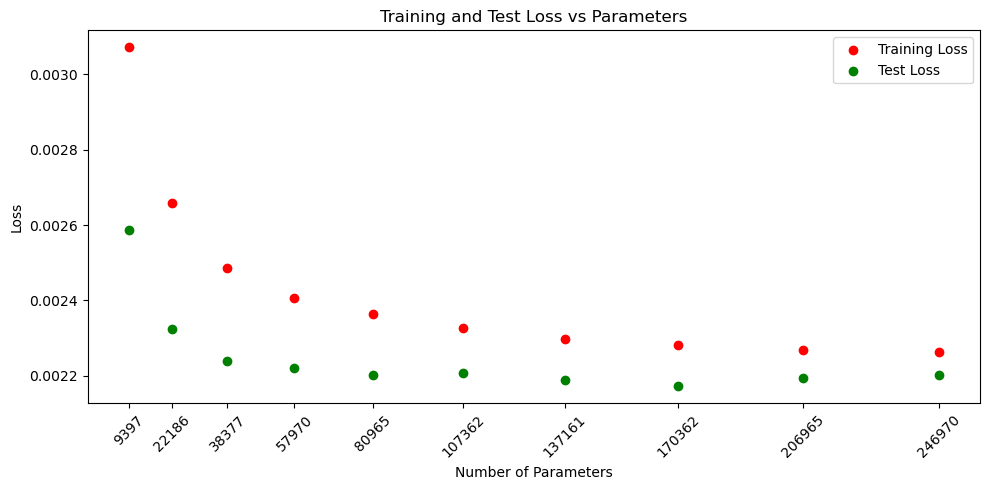

In [21]:
plt.figure(figsize=(10, 5))

plt.scatter(params_arr, train_loss_arr, color="red", label="Training Loss")
plt.scatter(params_arr, test_loss_arr, color="green", label="Test Loss")

plt.xticks(params_arr, rotation=45)

plt.title('Training and Test Loss vs Parameters')
plt.xlabel('Number of Parameters')
plt.ylabel('Loss')

plt.legend()

plt.tight_layout()
plt.show()


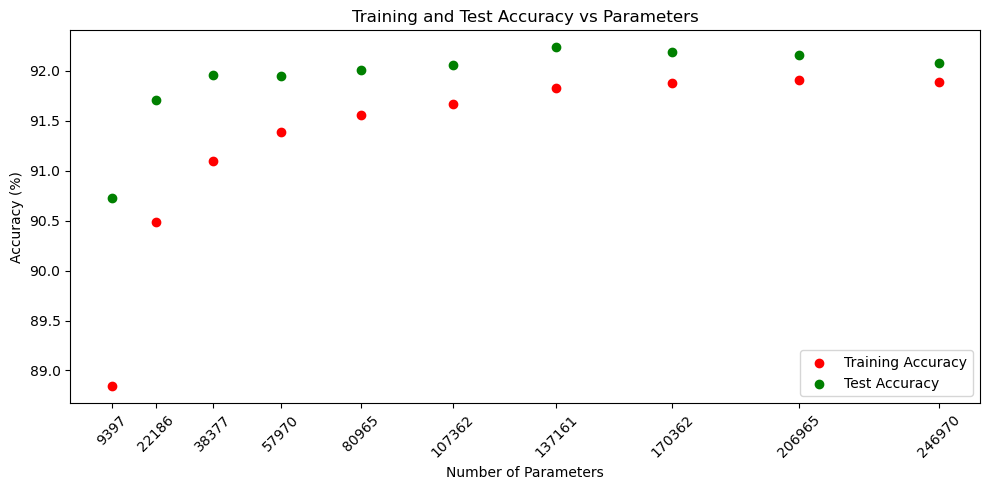

In [22]:
plt.figure(figsize=(10, 5))

plt.scatter(params_arr, train_acc_arr, color="red", label="Training Accuracy")
plt.scatter(params_arr, test_acc_arr, color="green", label="Test Accuracy")

plt.xticks(params_arr, rotation=45)

plt.title('Training and Test Accuracy vs Parameters')
plt.xlabel('Number of Parameters')
plt.ylabel('Accuracy (%)')

plt.legend()

plt.tight_layout()
plt.show()
